# Graph fusion with GraphRNN

Projected Outline
1. implement RNN/LTSM
2. get graphRNN working for simple graphs with no features
    - how to implement loss function
3. add features
4. add sampling/graph fusion stuff

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://github.com/snap-stanford/GraphRNN

## set-up

In [1]:
## imports
import numpy as np
import networkx
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I used Pytorch's implementation of the LSTM, described [here](https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html).

In [15]:
rnn = nn.LSTMCell(10, 20)
input = torch.randn(8, 3, 10)
hx = torch.randn(3, 20)
cx = torch.randn(3, 20)
output = []
for i in range(8):
    hx, cx = rnn(input[i], (hx, cx))
    output.append(hx)

In [16]:
len(output)

8

In [14]:
output[0].size()

torch.Size([3, 20])

In [2]:
# plain GRU model
class GRU_plain(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, has_input=True, has_output=False, output_size=None):
        super(GRU_plain, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.has_input = has_input
        self.has_output = has_output

        if has_input:
            self.input = nn.Linear(input_size, embedding_size)
            self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers,
                              batch_first=True)
        else:
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        if has_output:
            self.output = nn.Sequential(
                nn.Linear(hidden_size, embedding_size),
                nn.ReLU(),
                nn.Linear(embedding_size, output_size)
            )

        self.relu = nn.ReLU()
        # initialize
        self.hidden = None  # need initialize before forward run

        for name, param in self.rnn.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.25)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param,gain=nn.init.calculate_gain('sigmoid'))
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = torch.nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)#.cuda()

    def forward(self, input_raw, pack=False, input_len=None):
        if self.has_input:
            input = self.input(input_raw)
            input = self.relu(input)
        else:
            input = input_raw
        if pack:
            input = pack_padded_sequence(input, input_len, batch_first=True)
        output_raw, self.hidden = self.rnn(input, self.hidden)
        if pack:
            output_raw = pad_packed_sequence(output_raw, batch_first=True)[0]
        if self.has_output:
            output_raw = self.output(output_raw)
        # return hidden state at each time step
        return output_raw

In [3]:
rnn = GRU_plain(input_size=10, 
                embedding_size=10, 
                hidden_size=10, 
                num_layers=5, 
                has_input=True, 
                has_output=False).to(device)#.cuda()

In [ ]:
rnn.

## Graph Generation

In [19]:
G_BA = networkx.barabasi_albert_graph(20, 1, 123)
G_NWS = networkx.newman_watts_strogatz_graph(20, 4, 0.2, 123)

print(G_BA.number_of_nodes())
print(G_NWS.number_of_nodes())

20
20


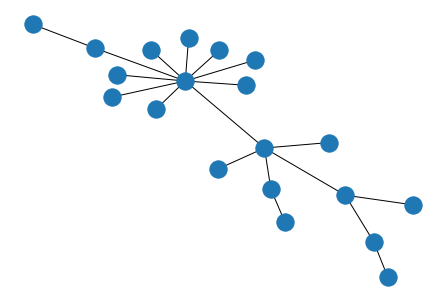

In [20]:
networkx.draw(G_BA)

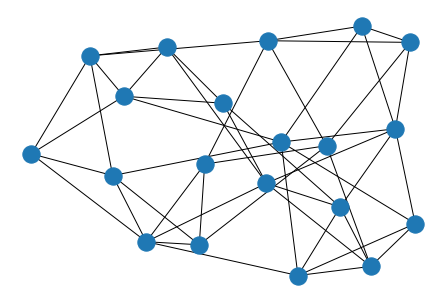

In [21]:
networkx.draw(G_NWS)